In [1]:
import requests
import json
import time
import pandas as pd
import numpy as np
from dydx3.constants import MARKET_DOGE_USD
from dydx3 import Client
from web3 import Web3
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'dydx3'

In [1]:
secret_key = "BAxYeS5iigF6M9eRqUv3guVLq35"

In [3]:
dydx_base = 'https://api.dydx.exchange'

In [4]:
client = Client(host=dydx_base)

In [2]:
asset = 'eth'

In [29]:
# load dydx data
dydx_candle = client.public.get_candles(market=asset.upper()+'-USD')
dydx_asset= pd.DataFrame((dydx_candle.data)['candles'])
dydx_asset['startedAt'] = dydx_asset['startedAt'].str.slice(0, 16)
dydx_asset['startedAt'] =pd.to_datetime(dydx_asset['startedAt'], format='%Y-%m-%dT%H:%M:%S')
dydx_asset.set_index('startedAt', inplace=True)
dydx_asset['close'] = pd.to_numeric(dydx_asset['close'], errors='coerce')

In [30]:
dydx_trades = client.public.get_trades(market=asset.upper()+'-USD')
dydx_trades = pd.DataFrame((dydx_trades.data)['trades'])
dydx_trades['createdAt'] = dydx_trades['createdAt'].str.slice(0, 16)
dydx_trades['createdAt'] = pd.to_datetime(dydx_trades['createdAt'], format='%Y-%m-%dT%H:%M:%S')
dydx_trades.set_index('createdAt', inplace=True)
dydx_trades['price'] = pd.to_numeric(dydx_trades['price'], errors='coerce')
dydx_trades['size'] = pd.to_numeric(dydx_trades['size'], errors='coerce')

In [31]:
# load gemini data

gemini_base = "https://api.gemini.com"

gemini_candle = requests.get(gemini_base + "/v2" + "/candles/"+asset+"usd/1m")
gemini_candle_json = gemini_candle.json()

gemini_trades = requests.get(gemini_base + "/v1" + "/trades/"+asset+"usd" + "?limit_trades=500")
gemini_trades_json = gemini_trades.json()

In [32]:
gemini_trades = pd.DataFrame(gemini_trades_json)
gemini_trades['timestampms'] = pd.to_datetime(gemini_trades['timestampms'], unit='ms')
gemini_trades.set_index('timestampms', inplace=True)

In [33]:
gemini_asset = pd.DataFrame(gemini_candle_json, columns=['t','o','h','l','c','v'])
gemini_asset['t'] = pd.to_datetime(gemini_asset['t']/1000, unit='s')
gemini_asset.set_index('t',inplace=True)
gemini_asset = gemini_asset[:dydx_asset.index[-1]]

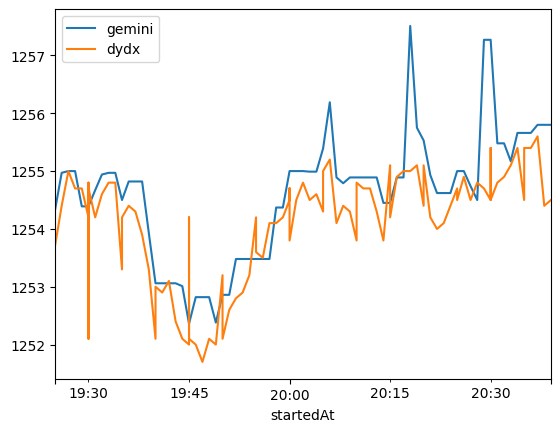

In [34]:
gemini_asset['c'].plot(label='gemini')
dydx_asset['close'].plot(label='dydx')
plt.legend()

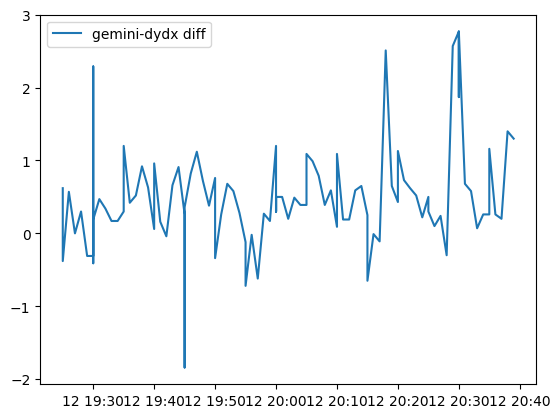

In [35]:
diff = gemini_asset['c'] - dydx_asset['close']
plt.plot(diff,label='gemini-dydx diff')
plt.legend()
plt.show()

In [36]:
num_trades_gemini = pd.to_numeric(gemini_trades['amount'][:gemini_asset.index[-1]]).sum()

# assume I can be the one trading 1% of all trades
realistic_tradeable = num_trades_gemini*0.01

gemini_maker_fee = 0.1/100

In [37]:
print('profit in 1.5 Hours of trading on gemini -> $',np.round(diff.sum()*realistic_tradeable * (1-gemini_maker_fee),4))

profit in 1.5 Hours of trading on gemini -> $ 155.5679


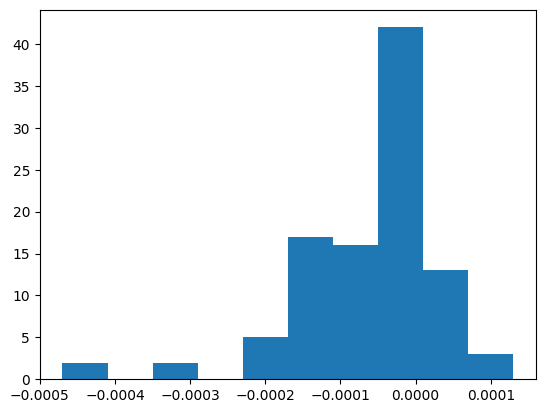

In [15]:
plt.hist(diff)
plt.show()

In [16]:
upper = diff.mean() + 1.96*diff.std()/np.sqrt(len(diff))
lower = diff.mean() - 1.96*diff.std()/np.sqrt(len(diff))

In [17]:
print('95% condfidnce for range of gemini-dydx discrepancy')
print('mean:',np.round(diff.mean(),5))
print('upper:',np.round(upper,5))
print('lower:',np.round(lower,5))

95% condfidnce for range of gemini-dydx discrepancy
mean: -6e-05
upper: -4e-05
lower: -8e-05


# Working with Orderbook

In [18]:
#dydx orderbook
dydx_orderbook = client.public.get_orderbook(
  market=asset.upper()+"-USD",)

In [19]:
dydx_asks = pd.DataFrame(dydx_orderbook.data['asks'])
dydx_bids = pd.DataFrame(dydx_orderbook.data['bids'])

In [20]:
dydx_asks['price'] = pd.to_numeric(dydx_asks['price'], errors='coerce')
dydx_asks['size'] = pd.to_numeric(dydx_asks['size'], errors='coerce')

dydx_bids['price'] = pd.to_numeric(dydx_bids['price'], errors='coerce')
dydx_bids['size'] = pd.to_numeric(dydx_bids['size'], errors='coerce')

In [21]:
#spread
dydx_spread = 1 - (dydx_bids['price'].iloc[0] / dydx_asks['price'].iloc[0])

In [22]:
# gemini orderbook
gemini_orderbook = requests.get(gemini_base + "/v1" + "/book/"+asset+"usd")
gemini_orderbook_json = gemini_orderbook.json()

In [23]:
gemini_asks = pd.DataFrame(gemini_orderbook_json['asks'])
gemini_bids = pd.DataFrame(gemini_orderbook_json['bids'])

gemini_asks['timestamp'] = pd.to_datetime(gemini_asks['timestamp'], unit='s')
gemini_bids['timestamp'] = pd.to_datetime(gemini_bids['timestamp'], unit='s')

gemini_asks['price'] = pd.to_numeric(gemini_asks['price'], errors='coerce')
gemini_asks['amount'] = pd.to_numeric(gemini_asks['amount'], errors='coerce')

gemini_bids['price'] = pd.to_numeric(gemini_bids['price'], errors='coerce')
gemini_bids['amount'] = pd.to_numeric(gemini_bids['amount'], errors='coerce')

In [24]:
#spread
gemini_spread = 1 - (gemini_bids['price'].iloc[0] / gemini_asks['price'].iloc[0])

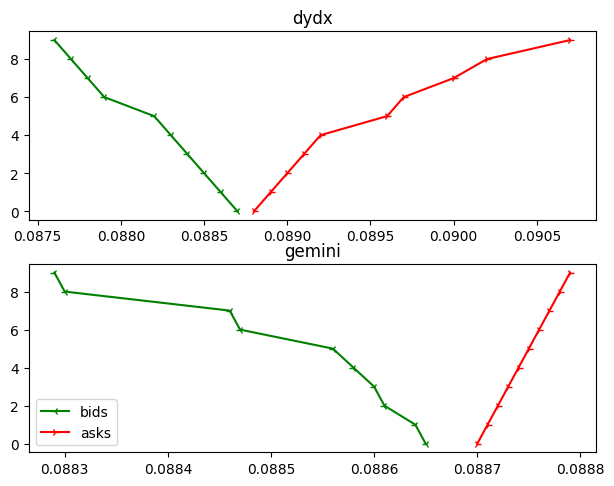

In [25]:
fig, axs = plt.subplots(2)
#fig.suptitle('Vertically stacked subplots')
fig.tight_layout()
depth = 10
axs[0].plot(dydx_bids['price'][:depth], range(depth), label='bids', color='g', marker='3')
axs[1].plot(gemini_bids['price'][:depth], range(depth), label='bids', color='g', marker='3')
axs[0].plot(dydx_asks['price'][:depth], range(depth), label='asks', color='r', marker='4')
axs[1].plot(gemini_asks['price'][:depth], range(depth), label='asks', color='r', marker='4')
axs[0].set_title('dydx')
axs[1].set_title('gemini')
axs[1].legend()

#start, end = axs[1].get_xlim()
#axs[0].xaxis.set_ticks(np.arange(start, end, 0.0003),rotation=90)

In [26]:
dydx_spread

0.0011261261261261701

In [27]:
gemini_spread

0.0005636978579480756

# Simulate Routing dydx orders to Gemini

In [622]:
budget = 1000
mins = 1
t_end = time.time() + 60 * mins
while time.time() < t_end:

    # get the orderbook data
    dydx_orderbook = client.public.get_orderbook(market=asset.upper()+"-USD",)
    gemini_orderbook = requests.get(gemini_base + "/v1" + "/book/"+asset+"usd")

    # use the second depth in dydx orderbook as buy and sell markers
    sell = float(dydx_orderbook.data['asks'][1]['price'])
    buy = float(dydx_orderbook.data['bids'][1]['price'])
    spread = sell-buy

    # if those markers are equal to what is at the top of the gemini orderbook, make a trader
    if buy == np.round(float(gemini_orderbook.json()['asks'][0]['price']),4):
        budget -= buy*1000
    if sell == np.round(float(gemini_orderbook.json()['bids'][0]['price']),4):
        budget += sell*1000

In [623]:
budget

1000